In [35]:
import torch
import torch.onnx
import models
import warnings
warnings.filterwarnings("ignore")

from tool import show_slices, nib_to_tensor

In [33]:
checkpoint_f = r'D:\Python_Projects\synthseg\models\LabelSamseg_unet_30000\checkpoint.pth.tar'
onnx_name = 'synthseg_unet_24.onnx'

pred_labels = [
    0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28,
    41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60
]
print(len(pred_labels))

device = "cpu"
print("device:", device)

torch_model = models.Unet3D(1, len(pred_labels), 24).to(device)
checkpoint = torch.load(checkpoint_f)
torch_model.load_state_dict(checkpoint['model_state_dict'])

33
device: cpu


<All keys matched successfully>

In [43]:
test_data = r"test_data\CANDI_BPDwoPsy_030_img.nii.gz"
img, _ = nib_to_tensor(nib.load(test_data))

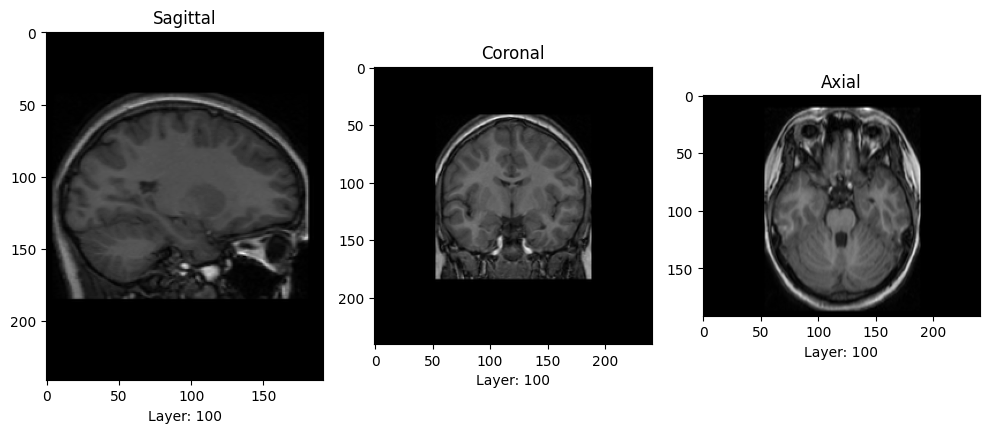

In [45]:
show_slices(img[0, 0, ...], (100, 100, 100), 'gray')

In [6]:
torch.onnx.export(torch_model,                                # model being run
                  torch.randn(1, 1, 28, 28, 28).to(device),    # model input (or a tuple for multiple inputs)
                  onnx_name,           # where to save the model (can be a file or file-like object)
                  input_names = ['input'],              # the model's input names
                  output_names = ['output'],    # the model's output names
                  dynamic_axes={'input': [2, 3, 4], 'out': [2, 3, 4]})  

# import onnx
# onnx_model = onnx.load(onnx_name)
# onnx.checker.check_model(onnx_model)

In [49]:
from nilearn.image import reorder_img, resample_img

def resample_voxel(data_nib, voxelsize, target_shape=None, interpolation='continuous'):
    affine = data_nib.affine
    target_affine = affine.copy()

    factor = np.zeros(3)
    for i in range(3):
        factor[i] = voxelsize[i] / \
            np.sqrt(affine[0, i]**2 + affine[1, i]**2 + affine[2, i]**2)
        target_affine[:3, i] = target_affine[:3, i]*factor[i]

    new_nib = resample_img(data_nib, target_affine=target_affine,
                            target_shape=target_shape, interpolation=interpolation)

    return new_nib

def resp_nib(input_nib, resample):
    input_nib_resp = reorder_img(input_nib, resample=resample)
    return resample_voxel(input_nib_resp, (1, 1, 1), interpolation=resample)

def rescale(image):
    return (image - image.min()) / (image.max() - image.min())

In [50]:
import nibabel as nib
import onnxruntime as ort
import numpy as np


x = resp_nib(nib.load(test_data), 'continuous').get_fdata().astype('float32')[None, None, ...]
x = rescale(x)

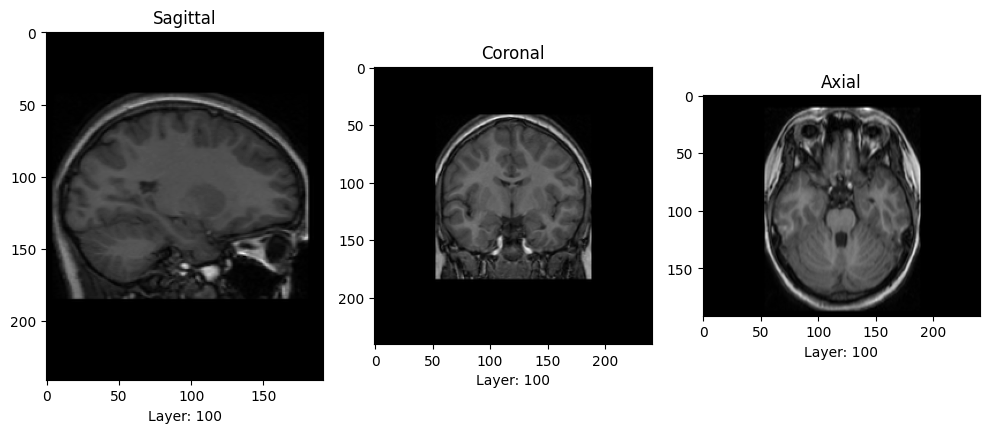

In [55]:
show_slices(x[0, 0, ...], (100, 100, 100), 'gray')

In [52]:
ort_sess = ort.InferenceSession(onnx_name, providers=["CPUExecutionProvider"])
logits = ort_sess.run(None, {'input': x})[0][0, ...]

In [53]:
mask_pred = np.argmax(logits, axis=0)
mask_pred_relabel = mask_pred * 0
for ii in range(len(pred_labels)):
    mask_pred_relabel[mask_pred == (ii + 1)] = pred_labels[ii]
    
mask_pred = mask_pred_relabel

(241, 192, 241)
[ 0  2 18]


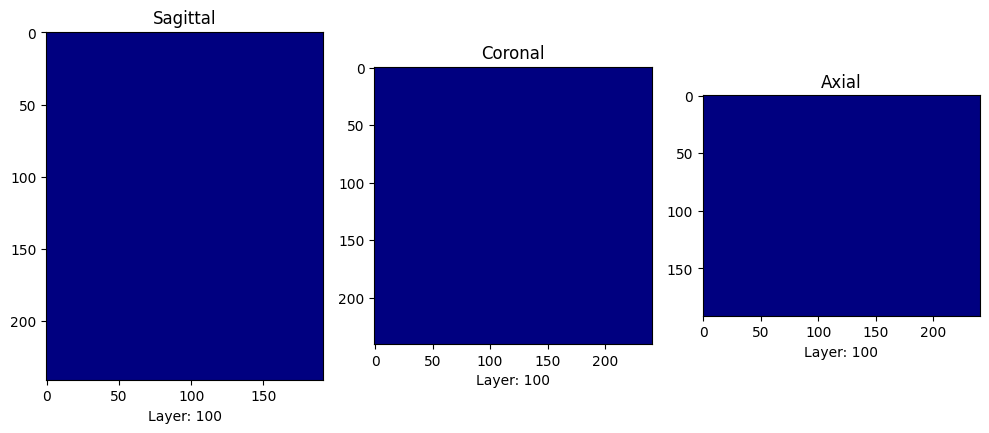

In [54]:
print(mask_pred.shape)
print(np.unique(mask_pred))
show_slices(mask_pred, (100, 100, 100), 'gist_ncar')